In [ ]:
%matplotlib widget
import numpy as np
from numpy.linalg import norm
from scipy.linalg import expm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [74]:
w01 = 2 * np.pi * 5e3
alpha = -350 * 2 * np.pi
nth = 0
gamma1 = 2 * np.pi * 1
gamma_phi = 2 * np.pi * 0.2
kappa = 0
Omegap = 2 * np.pi * 10
Omegas = 2 * np.pi * 0
wp = w01
ws = w01 * 2
g=0

In [75]:
def annihilation_operator(dim: int) -> np.ndarray:
    a = np.zeros((dim, dim), dtype=complex)
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)  # <n-1| a |n> = sqrt(n)
    return a

In [76]:
dimq = 3
dimr = 1

Iq = np.eye(dimq)
Ir = np.eye(dimr)
I = np.kron(Iq, Ir)

a_q = annihilation_operator(dimq)
a = np.kron(a_q, Ir)
a_dag = np.kron(a_q.conj().T, Ir)
a_drive = a + a_dag

b_r = annihilation_operator(dimr)
b = np.kron(Iq, b_r)
b_dag = np.kron(Iq, b_r.conj().T)
b_drive = b + b_dag

In [77]:
def H_0(w01: float, alpha: float, wr: float, g:float) -> np.ndarray:
    Hq = w01 * a_dag @ a + (alpha / 2) * a_dag @ a @ (a_dag @ a - I)
    Hr = wr * b_dag @ b
    Hint = g * (a_dag + a) @ (b_dag + b)
    return Hq + Hr + Hint

In [78]:
H0 = H_0(w01, alpha, 0, g)

In [79]:
L_list = [np.sqrt(gamma1 * (1 + nth)) * a, np.sqrt(gamma1 * nth) * a_dag,
          np.sqrt(kappa * (1 + nth)) * b, np.sqrt(kappa * nth) * b_dag, np.sqrt(gamma_phi) * a_dag @ a]
L_norm = [L.conj().T @ L for L in L_list]

In [80]:
J = np.zeros((dimq * dimr, dimq * dimr), dtype=complex)
for L in L_list:
    J += L.conj().T @ L

In [81]:
def H_full(t: float) -> np.ndarray:
    H_drive = Omegap * np.cos(wp * t) * a_drive + Omegas * np.cos(ws * t) * b_drive
    return H0 + H_drive - (1j / 2) * J

In [82]:
He = H0 - 1j / 2 * J
# He = H0

In [83]:
time = np.linspace(0, 1.0, 100000)

In [84]:
dt = time[1] - time[0]
dt

1.000010000100001e-05

In [85]:
psi_q = np.zeros(dimq, dtype=complex)
psi_q[0] = 1.0
psi_r = np.zeros(dimr, dtype=complex)
psi_r[0] = 1.0

psi0 = np.kron(psi_q, psi_r)


In [86]:
exp = np.exp(1j * wp * time)

In [139]:
num_trajectories = 100

In [150]:
psi_avg = np.zeros((len(time), dimq * dimr), dtype=complex)
g1 = np.zeros((len(time)//10,len(time)//10), dtype=complex)

sin_wp_t = np.sin(wp * time)
sin_ws_t = np.sin(ws * time)
pump_arr = (sin_wp_t[1:] - sin_wp_t[:-1]) * Omegap / wp
signal_arr = (sin_ws_t[1:] - sin_ws_t[:-1]) * Omegas / ws

N = 100
factor = 1j / N
A_static = np.eye(dimq * dimr, dtype=complex) - factor * He * dt
A_pump = -factor * a_drive
A_signal = -factor * b_drive

for _ in tqdm(range(num_trajectories)):
    psis = np.zeros((len(time), dimq * dimr), dtype=complex)
    a_tr = np.zeros(len(time), dtype=complex)
    psis[0] = psi0
    pl = np.zeros(len(L_list), dtype=float)
    for idx in range(1, len(time)):
        psi_prev = psis[idx - 1]
        dp = np.real(np.vdot(psi_prev, J @ psi_prev)) * dt

        if np.random.rand() > dp:
            pump = pump_arr[idx - 1]
            signal = signal_arr[idx - 1]
            A = A_static + pump * A_pump + signal * A_signal
            U = np.linalg.matrix_power(A, N)
            # U = expm(-1j * (He + pump * a_drive + signal * b_drive) * dt)
            psi = U @ psi_prev
        else:
            psi = psi_prev
            for i, Ln in enumerate(L_norm):
                pl[i] = np.real(np.vdot(psi, Ln @ psi))
            pl /= np.sum(pl)
            c = np.searchsorted(np.cumsum(pl), np.random.rand())
            psi = L_list[c] @ psi
            psi /= norm(psi)
        psis[idx] = psi #/ psi_norm
    a_tr *= exp
    a_psi = np.array([a @ psis[i] for i in range(len(time))])
    psis_sub = psis[::10]
    a_psi_sub = psis_sub @ a.T
    g1 += a_psi_sub.conj() @ a_psi_sub.T
    psi_avg += psis
psi_avg /= num_trajectories
g1 /= num_trajectories

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
psi_avg = np.zeros((len(time), dimq * dimr), dtype=complex)
g1 = np.zeros((len(time) // 10, len(time) // 10), dtype=complex)

sin_wp_t = np.sin(wp * time)
sin_ws_t = np.sin(ws * time)
pump_arr = (sin_wp_t[1:] - sin_wp_t[:-1]) * Omegap / wp
signal_arr = (sin_ws_t[1:] - sin_ws_t[:-1]) * Omegas / ws

N = 100
factor = 1j / N
A_static = np.eye(dimq * dimr, dtype=complex) - factor * He * dt
A_pump = -factor * a_drive
A_signal = -factor * b_drive

def run_trajectory(seed):
    # Seed the random number generator for this process
    np.random.seed(seed)

    psis = np.zeros((len(time), dimq * dimr), dtype=complex)
    psis[0] = psi0
    pl = np.zeros(len(L_list), dtype=float)

    for idx in range(1, len(time)):
        psi_prev = psis[idx - 1]
        dp = np.real(np.vdot(psi_prev, J @ psi_prev)) * dt

        if np.random.rand() > dp:
            pump = pump_arr[idx - 1]
            signal = signal_arr[idx - 1]
            A = A_static + pump * A_pump + signal * A_signal
            U = np.linalg.matrix_power(A, N)
            psi = U @ psi_prev
        else:
            psi = psi_prev
            for i, Ln in enumerate(L_norm):
                pl[i] = np.real(np.vdot(psi, Ln @ psi))
            pl /= np.sum(pl)
            c = np.searchsorted(np.cumsum(pl), np.random.rand())
            psi = L_list[c] @ psi
            psi /= norm(psi)
        psis[idx] = psi
    return psis

# Generate random seeds for reproducibility
seeds = np.random.randint(0, 1000000, size=num_trajectories)
# Run trajectories in parallel (n_jobs=-1 uses all available cores)
print(f"Running {num_trajectories} trajectories in parallel...")
results = Parallel(n_jobs=-1)(delayed(run_trajectory)(seed) for seed in tqdm(seeds))

# Aggregate results
psi_avg = np.zeros((len(time), dimq * dimr), dtype=complex)
g1 = np.zeros((len(time) // 10, len(time) // 10), dtype=complex)

print("Aggregating results...")
for psis in tqdm(results, desc="Aggregating"):
    psi_avg += psis

    # Vectorized g1 calculation
    psis_sub = psis[::10]
    a_psi_sub = psis_sub @ a.T
    g1 += a_psi_sub.conj() @ a_psi_sub.T

Running 100 trajectories in parallel...


  0%|          | 0/100 [00:00<?, ?it/s]

Aggregating results...


Aggregating:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (10000,10000) (3,3) (10000,10000) 

In [154]:
# Aggregate results
psi_avg = np.zeros((len(time), dimq * dimr), dtype=complex)
g1 = np.zeros((len(time) // 10, len(time) // 10), dtype=complex)

print("Aggregating results...")
for psis in tqdm(results, desc="Aggregating"):
    psi_avg += psis

    # Vectorized g1 calculation
    psis_sub = psis[::10]
    a_psi_sub = psis_sub @ a.T
    g1 += a_psi_sub.conj() @ a_psi_sub.T

Aggregating results...


Aggregating:   0%|          | 0/100 [00:00<?, ?it/s]

In [156]:
t1, t2 = np.meshgrid(time[::10], time[::10], indexing='ij')
tau = t2 - t1
exp_2d = np.exp(1j * wp * tau)
g1_copy = g1 * exp_2d

In [157]:
np.real(g1 - g1_copy).max(), np.real(g1).max()

(1091.1312789297317, 1039.8643359399837)

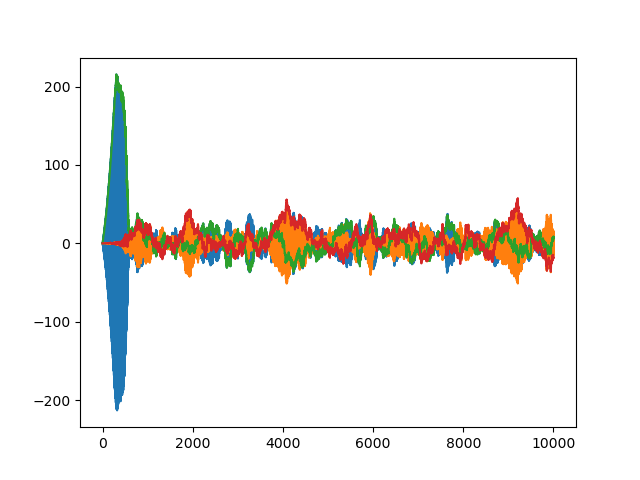

In [158]:
plt.figure()
y = 250
plt.plot(g1.real[:, y])
plt.plot(g1.imag[:, y])
plt.plot(g1_copy.real[:, y])
plt.plot(g1_copy.imag[:, y])

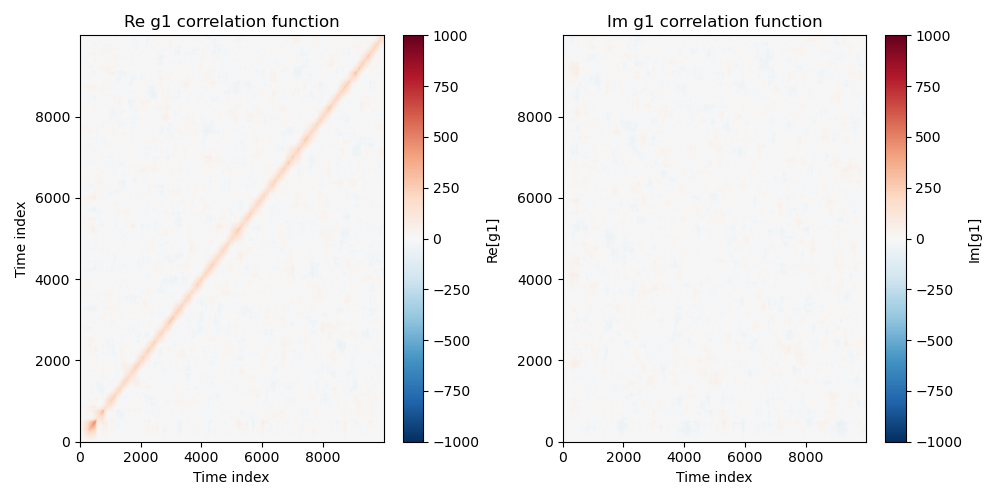

In [162]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
Vmax = 1000
im0 = axs[0].imshow(np.real(g1_copy), aspect='auto', cmap='RdBu_r', origin='lower', vmin=-Vmax, vmax=Vmax)
fig.colorbar(im0, ax=axs[0], label='Re[g1]')
axs[0].set_xlabel('Time index')
axs[0].set_ylabel('Time index')
axs[0].set_title('Re g1 correlation function')

im1 = axs[1].imshow(np.imag(g1_copy), aspect='auto', cmap='RdBu_r', origin='lower', vmin=-Vmax, vmax=Vmax)
fig.colorbar(im1, ax=axs[1], label='Im[g1]')
axs[1].set_xlabel('Time index')
axs[1].set_title('Im g1 correlation function')

plt.tight_layout()
plt.show()

In [146]:
g1_spec = np.fft.fftshift(np.fft.fft(g1, axis=0), axes=0)
g1_freqs = np.fft.fftshift(np.fft.fftfreq(g1.shape[0], d=dt*100))

In [147]:
np.max(np.abs(g1_spec))

192.8345667675856

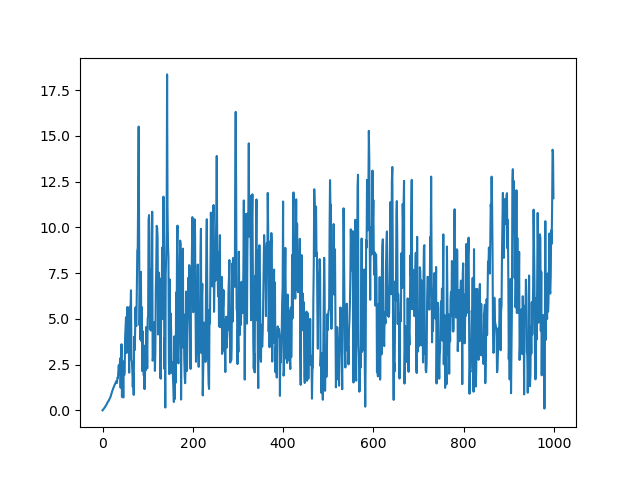

In [148]:
plt.figure()
plt.plot(np.abs(g1_spec[0]))

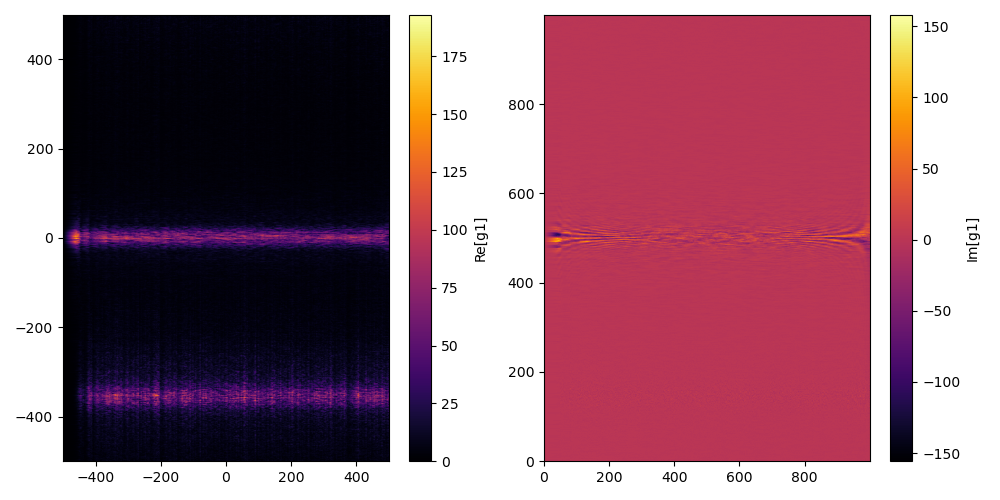

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(np.abs(g1_spec), aspect='auto', cmap='inferno', origin='lower', extent=(g1_freqs[0], g1_freqs[-1], g1_freqs[0], g1_freqs[-1]))
fig.colorbar(im0, ax=axs[0], label='Re[g1]')

im1 = axs[1].imshow(np.imag(g1_spec), aspect='auto', cmap='inferno', origin='lower')
fig.colorbar(im1, ax=axs[1], label='Im[g1]')

plt.tight_layout()
plt.show()

In [99]:
a_mean = np.zeros(len(time), dtype=complex)
n_mean = np.zeros(len(time), dtype=complex)
for idx, psi in enumerate(psi_avg):
    a_mean[idx] = np.vdot(psi, a @ psi)
    n_mean[idx] = np.vdot(psi, a_dag @ a @ psi)

In [100]:
pr0 = [np.vdot(psi_avg[i], psi0) for i in range(len(time))]

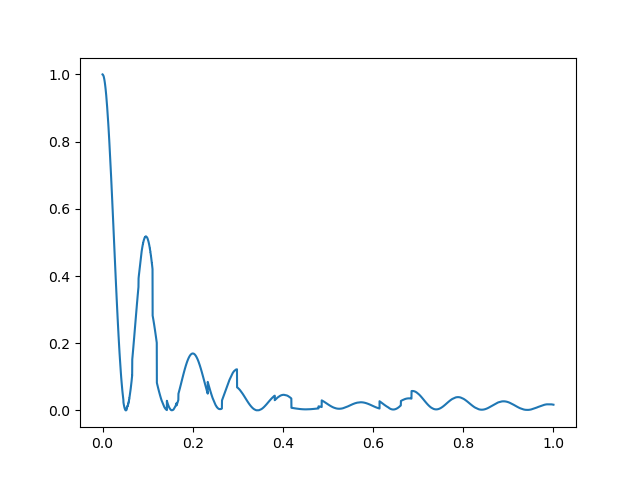

In [101]:
plt.figure()
plt.plot(time, np.abs(pr0)**2)

In [102]:
exp = np.exp(1j * w01 * time)

C:\Users\dfavadf\AppData\Local\Temp\ipykernel_42556\1664393537.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


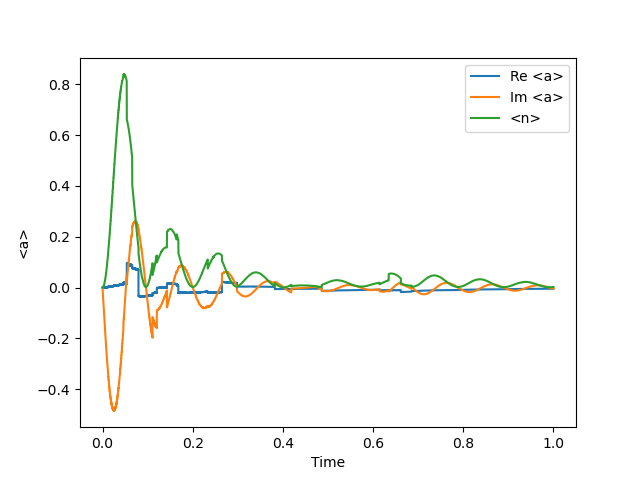

In [103]:
plt.figure()
plt.plot(time, np.real(a_mean * exp), label='Re <a>')
plt.plot(time, np.imag(a_mean*exp), label='Im <a>')
# plt.plot(time, np.abs(a_mean*exp), label='|<a>|')
plt.plot(time, np.real(n_mean), label='<n>')
plt.xlabel('Time')
plt.ylabel('<a>')
plt.legend()
plt.show()


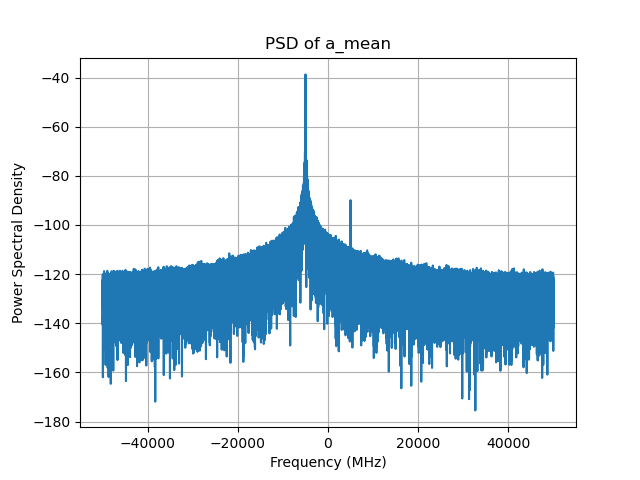

In [104]:
plt.figure()
plt.magnitude_spectrum(a_mean, Fs=1/dt, scale='dB')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density')
plt.title('PSD of a_mean')
plt.grid(True)
plt.show()

c:\Users\dfavadf\anaconda3\envs\sim\Lib\site-packages\scipy\signal\_spectral_py.py:589: UserWarning: nperseg = 204800 is greater than input length  = 100000, using nperseg = 100000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\dfavadf\anaconda3\envs\sim\Lib\site-packages\scipy\signal\_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


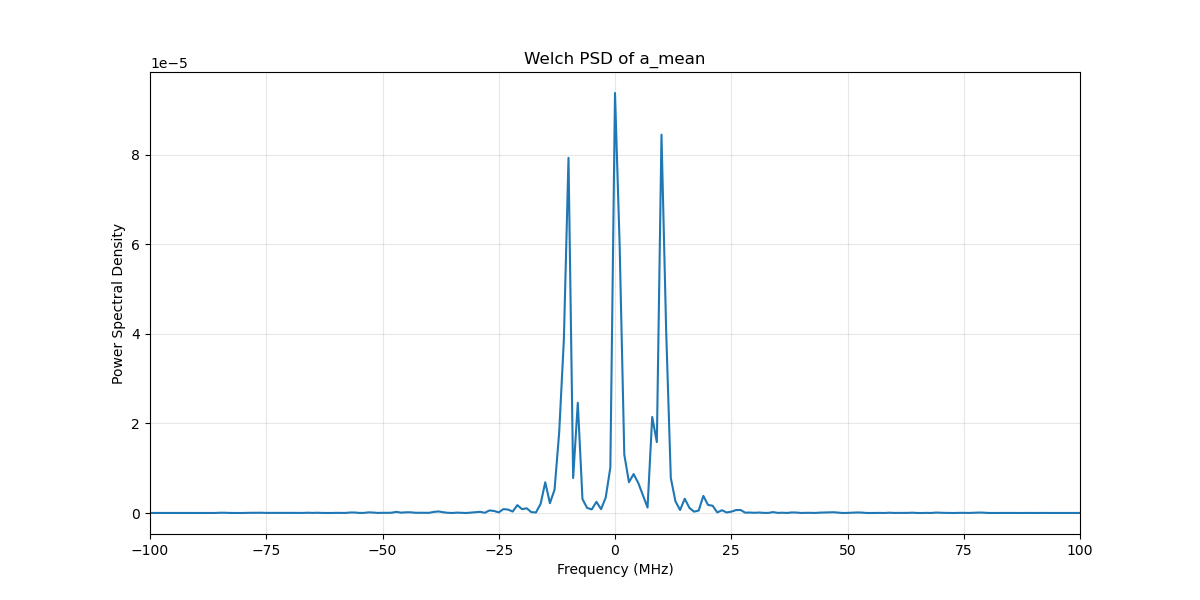

In [105]:
from scipy import signal

# Compute Welch power spectral density
frequencies_welch, psd_welch = signal.welch(a_mean*exp, fs=1/dt, nperseg=40960*5)
fft_values_welch = np.fft.fftshift(frequencies_welch)
psd_welch_shifted = np.fft.fftshift(psd_welch)

# Plot Welch PSD
plt.figure(figsize=(12, 6))
plt.plot(fft_values_welch, psd_welch_shifted)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density')
plt.title('Welch PSD of a_mean')
plt.xlim(-1e2, 1e2)
plt.grid(True, which='both', alpha=0.3)
plt.show()